In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline
plt.ioff()
sns.set_style('darkgrid')
sns.set_context('talk')

In [3]:
from utilities import *

In [4]:
%load_ext autoreload
%autoreload 2

# Part 1: Load and Examine the Data

In [5]:
col_rename = lambda df : df.rename(lambda s : s.lower().replace(' ', '_'), axis = 'columns')

data           = col_rename(pd.read_csv('movie_train.csv', index_col=0))
out_of_sample  = col_rename(pd.read_csv('movie_test.csv' , index_col=0))
oos = out_of_sample # alias

data.head()

,release_year,title,plot,director,cast,genre
10281,1984,Silent Madness,A computer error leads to the accidental relea...,Simon Nuchtern,"Belinda Montgomery, Viveca Lindfors",horror
7341,1960,Desire in the Dust,"Lonnie Wilson (Ken Scott), the son of a sharec...",Robert L. Lippert,"Raymond Burr, Martha Hyer, Joan Bennett",drama
10587,1986,On the Edge,"A gaunt, bushy-bearded, 44-year-old Wes Holman...",Rob Nilsson,"Bruce Dern, Pam Grier",drama
25495,1988,Ram-Avtar,Ram and Avtar are both childhood best friends....,Sunil Hingorani,"Sunny Deol, Anil Kapoor, Sridevi",drama
16607,2013,Machete Kills,Machete Cortez (Danny Trejo) and Sartana River...,Robert Rodriguez,"Danny Trejo, Michelle Rodriguez, Sofía Vergara...",action


In [6]:
# Convenience function to view calls on 
#  training data and out-of-sample data
#  simultaneously
def compare(*attrs):
    ss = [data, out_of_sample]
    for attr in attrs:
        if attr[-2:] == '()':
            ss = lmap(lambda s : s.__getattr__(attr[:-2]).__call__(), ss)
        else:
            ss = lmap(lambda s : s.__getattr__(attr), ss)
    ss = [s.rename(name) for s, name in zip(ss, ['data', 'out_of_sample'])]
    return pd.concat(ss, axis = 'columns', sort = True)

In [7]:
# Check correct loading of datatypes
compare('dtypes')

,data,out_of_sample
cast,object,object
director,object,object
genre,object,NaN
plot,object,object
release_year,int64,int64
title,object,object


## 1 - Look for missing values

In [8]:
compare('isna()', 'sum()')

,data,out_of_sample
cast,169,57.0
director,0,0.0
genre,0,NaN
plot,0,0.0
release_year,0,0.0
title,0,0.0


In [9]:
print(data.shape, oos.shape)

(10682, 6) (3561, 5)


In [10]:
data[data.cast.isna()].head()

,release_year,title,plot,director,cast,genre
22523,2004,Kekexili: Mountain Patrol,The film opens with the summary execution of a...,Lu Chuan,NaN,drama
34135,2007,Dead Daughters,"In present-day Moscow, a woman Vera (Daria Cha...",Pavel Ruminov,NaN,horror
12958,1997,Defying Gravity,"John ""Griff"" Griffith, an average college stud...",John Keitel,NaN,drama
12937,1997,Cannibal Rollerbabes,When Scott is fired from Local Diner because h...,Unknown,NaN,horror
22329,2013,Stay,"The movie Stay, based on the novel by Aislinn ...",Wiebke von Carolsfeld,NaN,drama


## 1 - Look at the target

In [11]:
data.genre.value_counts()

drama        3770
comedy       2724
horror        840
action        830
thriller      685
romance       649
western       525
adventure     331
crime         328
Name: genre, dtype: int64

## 1 - Look at the overlap of directors

In [12]:
# There is pretty substantial overlap in directorship
#  Note that 'unknown' is a director
directors = compare('director', 'value_counts()').sort_values('out_of_sample', ascending = False)
directors = directors[(~directors.data.isna()) & (~directors.out_of_sample.isna())]
print(directors.sum())
directors.head()

data             5130.0
out_of_sample    2354.0
dtype: float64


,data,out_of_sample
Unknown,99.0,36.0
Lesley Selander,24.0,11.0
Allan Dwan,12.0,9.0
Charles Lamont,7.0,9.0
Otto Preminger,6.0,8.0


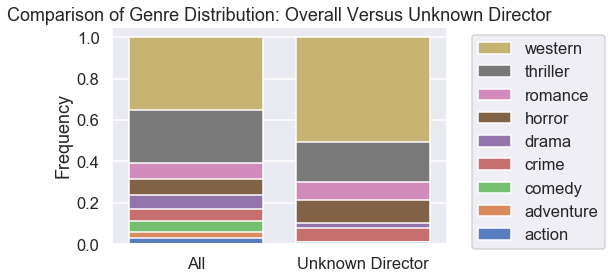

In [13]:
# There appears to be substantial information available in the unknown directors
fig, ax = stacked_countplot(
                  data.genre.rename('All'),
                  data[data.director == 'Unknown'].genre.rename('Unknown Director'),
                  normalize = True
                 )
ax.set_title('Comparison of Genre Distribution: Overall Versus Unknown Director')
fig

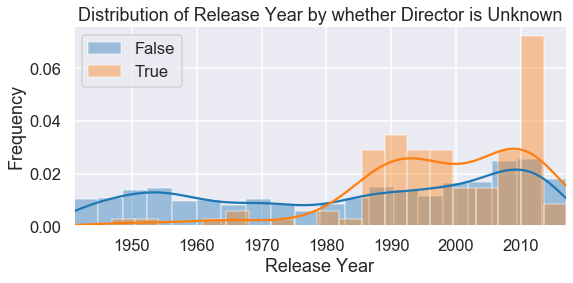

In [14]:
data['is_unknown_director'] = data.director == 'Unknown'

g = sns.FacetGrid(data, hue = 'is_unknown_director', height = 4, aspect = 2)
g.map(sns.distplot, 'release_year', bins = 20)

ax = g.fig.axes[0]
ax.set_xlim([data.release_year.min(), data.release_year.max()])
ax.set_xlabel('Release Year')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Release Year by whether Director is Unknown')
ax.legend()

drop_col(data, 'is_unknown_director')

g.fig

In [15]:
# Many directors have only one movie in the training data
directors[directors.data == 1]

,data,out_of_sample
Robert Ellis Miller,1.0,4.0
Ben Stiller,1.0,4.0
S. V. Krishna Reddy,1.0,4.0
Roy William Neill,1.0,3.0
Anil Sharma,1.0,3.0
...,...,...
James Kenelm Clarke,1.0,1.0
James Keach,1.0,1.0
James F. Collier,1.0,1.0
James Cameron,1.0,1.0


Mean number of effective genres: 2.0


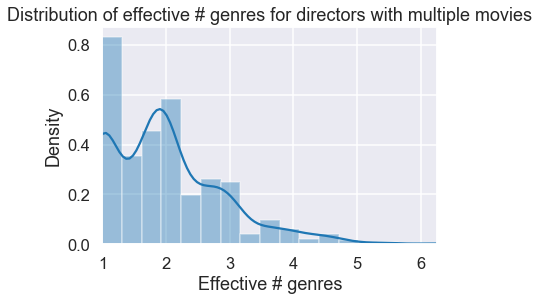

In [16]:
# Let's get a sense for how much information we can extract by
# computing the inverse herfindahl index on the 
# training data directors. This is the effective number
# of genres directed by a director.
def herfindahl_index(series):
    series = series.value_counts()
    return 1 / ((series/series.sum())**2).sum()
    
prolific_directors    = directors[directors.data > 1].data.index
prolific_directors    = data.director.isin(prolific_directors)

h = data[prolific_directors].groupby('director').genre.apply(herfindahl_index)
print(f'Mean number of effective genres: {round(h.mean(),1)}')

fig, ax = plt.subplots()
sns.distplot(h, ax = ax)
ax.set_xlim([1, max(h)])
ax.set_xlabel('Effective # genres')
ax.set_ylabel('Density')
ax.set_title('Distribution of effective # genres for directors with multiple movies')
fig

## 1 - Look for uncoded missing values in plot

In [17]:
plot_len = data['plot'].apply(len).sort_values()
data.loc[plot_len.iloc[:5].index]

,release_year,title,plot,director,cast,genre
24876,1973,Chhalia,Chhalia is a family thriller.,Mukul Dutt,"Navin Nischol, Nanda, Shatrughan Sinha",action
6210,1954,They Were So Young,"""A beach near Rio de Janeiro"".",Kurt Neumann,"Raymond Burr, Scott Brady, Johanna Matz",drama
7382,1960,Noose for a Gunman,A gunman takes on a corrupt land baron.,Edward L. Cahn,"Jim Davis, Lyn Thomas",western
4075,1945,A Medal for Benny,The film examines small town hypocrisy.,Irving Pichel,"Dorothy Lamour, Arturo de Córdova",drama
25919,1997,Suraj,Suraj is an Action film for Mithun Fans.,T.L.V. Prasad,"Rakesh Bedi, Mithun Chakraborty, Puneet Issar",action


In [18]:
plot_len = oos['plot'].apply(len).sort_values()
oos.loc[plot_len.iloc[:5].index]

,release_year,title,plot,director,cast
7429,1960,Walk Like a Dragon,Film's introduction:,James Clavell,"Jack Lord, Nobu McCarthy, Mel Torme"
22731,2014,Blind Massage,The film is set in Nanjing.[1],Lou Ye,"Guo Xiaodong, Qin Hao, Zhang Lei, Mei Ting, Hu..."
17972,2007,Doctor Bari,The film is about three doctors.,M Azijur Rahman,"Shakib Khan, Shabnaz"
17608,1991,Deadly,From the UK VHS slick for the movie:,Esben Storm,"Jerome Ehlers, Frank Gallacher, Lydia Miller"
18965,1951,Death Is a Number,A man is persecuted by the number 9.,Robert Henryson,"Terence Alexander, Lesley Osmond, Ingeborg von..."


In [19]:
data

,release_year,title,plot,director,cast,genre
10281,1984,Silent Madness,A computer error leads to the accidental relea...,Simon Nuchtern,"Belinda Montgomery, Viveca Lindfors",horror
7341,1960,Desire in the Dust,"Lonnie Wilson (Ken Scott), the son of a sharec...",Robert L. Lippert,"Raymond Burr, Martha Hyer, Joan Bennett",drama
10587,1986,On the Edge,"A gaunt, bushy-bearded, 44-year-old Wes Holman...",Rob Nilsson,"Bruce Dern, Pam Grier",drama
25495,1988,Ram-Avtar,Ram and Avtar are both childhood best friends....,Sunil Hingorani,"Sunny Deol, Anil Kapoor, Sridevi",drama
16607,2013,Machete Kills,Machete Cortez (Danny Trejo) and Sartana River...,Robert Rodriguez,"Danny Trejo, Michelle Rodriguez, Sofía Vergara...",action
...,...,...,...,...,...,...
4652,1948,Fighting Back,Nick Sanders comes home from the war and needs...,Malcolm St. Clair,"Jean Rogers, Paul Langton",drama
23220,1987,The Romance of Book and Sword,The film covers the first half of the novel an...,Ann Hui,"Zhang Duofu, Chang Dashi, Liu Jia",action
15847,2010,Holy Rollers,"Sam Gold (Jesse Eisenberg), is a mild-mannered...",Kevin Asch,"Jesse Eisenberg, Justin Bartha, Ari Graynor, D...",drama
3102,1941,Lady from Louisiana,Yankee lawyer John Reynolds (John Wayne) and S...,Bernard Vorhaus,"John Wayne, Ona Munson",drama
